# Importamos librerias a utlizar

In [1]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model
import docplex.mp.solution as solucion

# Los conjuntos de datos

### Primero inventaremos datos aleatorios

In [5]:
n = 10 #10 ciudades
ciudades = [i for i in range (n)]
aristas = [(i,j) for i in ciudades for j in ciudades if i!=j]
ciudades, print(aristas)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 0), (3, 1), (3, 2), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 6), (5, 7), (5, 8), (5, 9), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 7), (6, 8), (6, 9), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 8), (7, 9), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 9), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8)]


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], None)

### Crear coordenadas aleatorias para cada ciudad, en un mapa de 100x100

In [6]:
random=np.random
random.seed(1)

coordenada_x = random.rand(n)*100
coordenada_y = random.rand(n)*100

print(f"coordenadas X para todas las ciudades: \n {coordenada_x}")
print(f"\nCoordenadas Y para todas las ciudades\n {coordenada_y}")

coordenadas X para todas las ciudades: 
 [4.17022005e+01 7.20324493e+01 1.14374817e-02 3.02332573e+01
 1.46755891e+01 9.23385948e+00 1.86260211e+01 3.45560727e+01
 3.96767474e+01 5.38816734e+01]

Coordenadas Y para todas las ciudades
 [41.91945144 68.52195004 20.44522497 87.81174364  2.73875932 67.04675102
 41.73048024 55.86898284 14.03869386 19.81014891]


### Podriamos visualizarlas mejor en un scatterplot

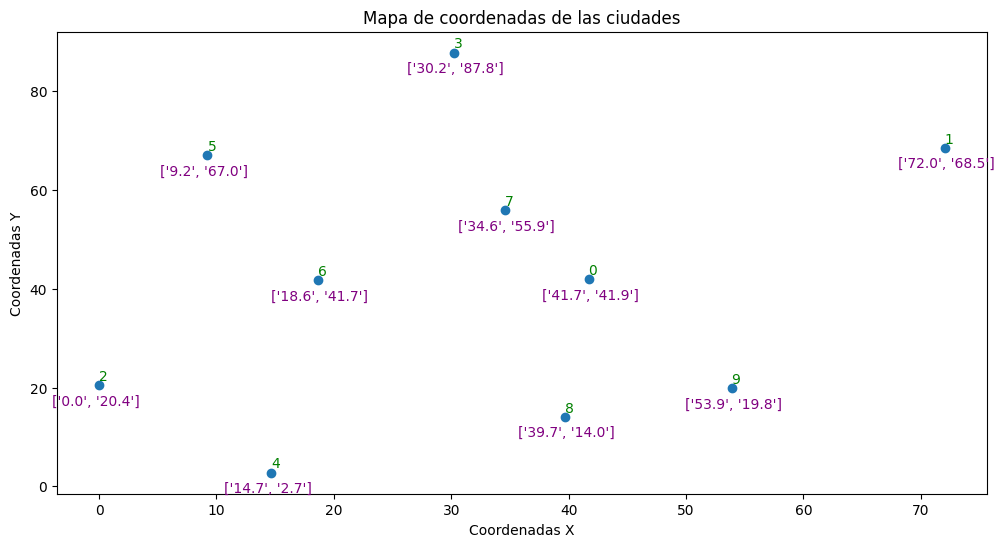

In [7]:
x=coordenada_x
y=coordenada_y

plt.figure(figsize=(12,6))
plt.scatter(coordenada_x,coordenada_y)
plt.title("Mapa de coordenadas de las ciudades")
plt.xlabel("Coordenadas X")
plt.ylabel("Coordenadas Y")


#Obtenemos las coordendas de cada ciudad para mostrala en el mapa
s = []
for i in range(len(coordenada_x)):
    s_temp = []
    s_temp.append("%.1f"%coordenada_x[i])#coordenada X
    s_temp.append("%.1f"%coordenada_y[i])#coordenada Y
    s.append(s_temp)#agrego [coordenada_x, coordenada_y] a la lista s.

#Mostramos en el mapa
for i in range(len(s)):
    plt.annotate(str(s[i]), xy=(coordenada_x[i], coordenada_y[i]), xytext=(coordenada_x[i]-4, coordenada_y[i]-4),
                 color='purple')
#Ahora identificamos cada ciudad- Numeros
for i in range(len(s)):
    plt.annotate(str(i), xy=(coordenada_x[i], coordenada_y[i]), xytext=(coordenada_x[i], coordenada_y[i]+1), color='green')
    
plt.show()

### Ahora la gracia es buscar el ciclo más corto que recorre todas las ciudades minimizando la distancia total recorrida.
### Por lo que se calulará las distancias que hay entre todas las ciudades de forma euclidiana.

In [8]:
costos = {}

for i,j in aristas:
    costos[(i,j)] = np.hypot(coordenada_x[i] - coordenada_x[j], coordenada_y[i] - coordenada_y[j])



# Creación del modelo

In [6]:
#Creamos la instancia del modelo
modelo = Model('Vendedor viajero')

#Creamos las variables de desicion
x=modelo.binary_var_dict(aristas, name='x')
d=modelo.continuous_var_dict(ciudades, name='d')

#Funcion objetivo
modelo.minimize(modelo.sum(costos[i]*x[i] for i in aristas))

#Restricciones

#restricion de salida
for c in ciudades:
    modelo.add_constraint(modelo.sum(x[(i,j)] for i,j in aristas if i==c)==1, ctname='Salida_%d' %c)
#La suma de todas las posibles salidas de una ciudad c debe ser 1, se debe salir por un camino de una ciudad.
    
#restriccion de entrada
for c in ciudades:
    modelo.add_constraint(modelo.sum(x[(i,j)] for i,j in aristas if j==c)==1, ctname='Entrada_%d' %c)
#La suma de todas las posibles entradas de una ciudad c deben ser 1, se debe entrar por un camino a la ciudad.
    
# Eliminacion de subciclos (subtours)
for i,j in aristas:
    if j!=0:
        modelo.add_indicator(x[(i,j)], d[i]+1==d[j], name='order_(%d,_%d)'%(i,j))
    

In [7]:
print(modelo.export_to_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Vendedor viajero

Minimize
 obj: 40.343734686869 x_0_1 + 46.896291121248 x_0_2 + 47.303690570017 x_0_3
      + 47.597944894625 x_0_4 + 41.055746868377 x_0_5 + 23.076953063631 x_0_6
      + 15.673435119506 x_0_7 + 27.954232297204 x_0_8 + 25.242044673501 x_0_9
      + 40.343734686869 x_1_0 + 86.593288670761 x_1_2 + 46.035514504947 x_1_3
      + 87.276787294567 x_1_4 + 62.815914396591 x_1_5 + 59.749723246000 x_1_6
      + 39.554726454581 x_1_7 + 63.366526264285 x_1_8 + 51.983557369704 x_1_9
      + 46.896291121248 x_2_0 + 86.593288670761 x_2_1 + 73.834993248941 x_2_3
      + 22.990351630210 x_2_4 + 47.505318619606 x_2_5 + 28.276577167726 x_2_6
      + 49.479030350176 x_2_7 + 40.179353574340 x_2_8 + 53.873979243543 x_2_9
      + 47.303690570017 x_3_0 + 46.035514504947 x_3_1 + 73.834993248941 x_3_2
      + 86.483834907091 x_3_4 + 29.532348805135 x_3_5 + 47.520635172848 x_3_6
      + 32.233937092975 x_3_7 + 74.375

# Resolver el modelo

In [8]:
solucion = modelo.solve(log_output=True)

Version identifier: 22.1.1.0 | 2022-11-26 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve modified 36 coefficients.
Aggregator did 36 substitutions.
Reduced MIP has 65 rows, 145 columns, and 315 nonzeros.
Reduced MIP has 90 binaries, 0 generals, 0 SOSs, and 81 indicators.
Presolve time = 0.00 sec. (0.25 ticks)
Probing time = 0.00 sec. (0.14 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 65 rows, 145 columns, and 315 nonzeros.
Reduced MIP has 90 binaries, 0 generals, 0 SOSs, and 81 indicators.
Presolve time = 0.02 sec. (0.21 ticks)
Probing time = 0.00 sec. (0.14 ticks)
Clique table members: 56.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.00 sec. (0.11 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    I

### Revisar si la solucion es optima

In [9]:
modelo.get_solve_status()

<JobSolveStatus.OPTIMAL_SOLUTION: 2>

### Obtener la solucion optima y el valor de la funcion objetivo

In [10]:
solucion.display()

solution for: Vendedor viajero
objective: 277.076
status: OPTIMAL_SOLUTION(2)
x_0_7 = 1
x_1_3 = 1
x_2_4 = 1
x_3_5 = 1
x_4_8 = 1
x_5_6 = 1
x_6_2 = 1
x_7_1 = 1
x_8_9 = 1
x_9_0 = 1
d_1 = 2.000
d_2 = 6.000
d_3 = 3.000
d_4 = 7.000
d_5 = 4.000
d_6 = 5.000
d_7 = 1.000
d_8 = 8.000
d_9 = 9.000


# Graficar la solucion

In [11]:
aristas_activas = [i for i in aristas if x[i].solution_value>0.9]
aristas_activas

[(0, 7),
 (1, 3),
 (2, 4),
 (3, 5),
 (4, 8),
 (5, 6),
 (6, 2),
 (7, 1),
 (8, 9),
 (9, 0)]

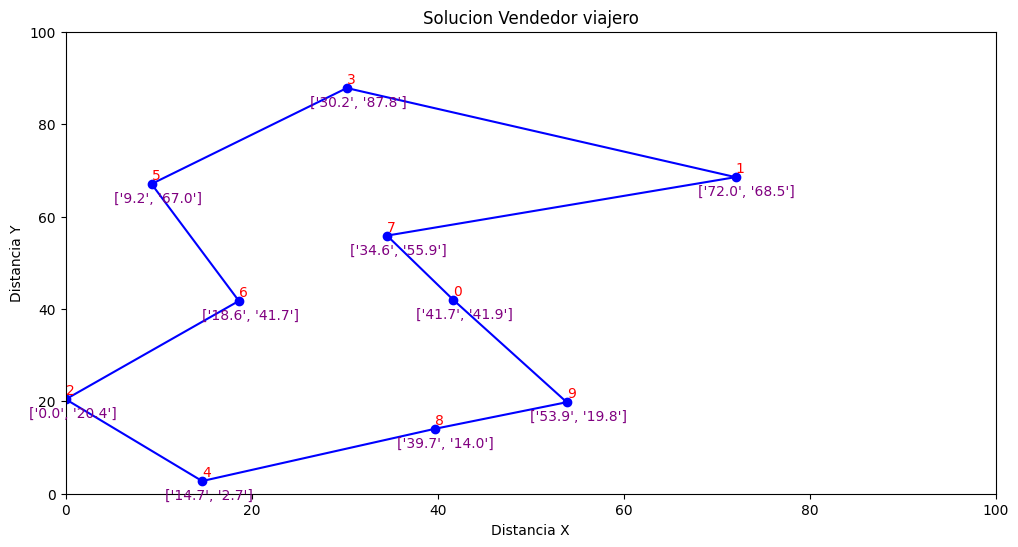

In [12]:
plt.figure(figsize=(12,6))
plt.xlabel("Distancia X")
plt.ylabel("Distancia Y")
plt.title("Solucion Vendedor viajero")
plt.xlim((0,100))
plt.ylim((0,100))

plt.scatter(x=coordenada_x, y=coordenada_y, color='blue', zorder=1)

for i,j in aristas_activas:
    plt.plot([coordenada_x[i], coordenada_x[j]], [coordenada_y[i], coordenada_y[j]], color='blue', zorder=1)
    
#Mostramos en el mapa
for i in range(len(coordenada_x)):
    plt.annotate(str(s[i]), xy=(coordenada_x[i], coordenada_y[i]), xytext=(coordenada_x[i]-4, coordenada_y[i]-4),
                 color='purple')
#Ahora identificamos cada ciudad
for i in range(len(coordenada_x)):
    plt.annotate(str(i), xy=(coordenada_x[i], coordenada_y[i]), xytext=(coordenada_x[i], coordenada_y[i]+1), color='red')
    
plt.show()

# Experimentos computacionales

* ### Tecnica Heuristica (vecino más cercano)

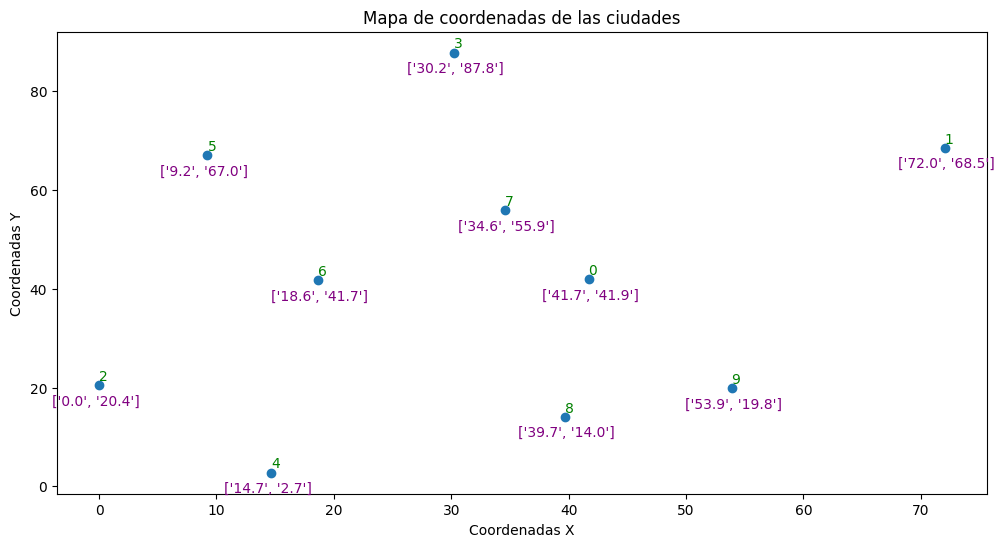

In [13]:
plt.figure(figsize=(12,6))
plt.scatter(coordenada_x,coordenada_y)
plt.title("Mapa de coordenadas de las ciudades")
plt.xlabel("Coordenadas X")
plt.ylabel("Coordenadas Y")


#Obtenemos las coordendas de cada ciudad para mostrala en el mapa
s = []
for i in range(len(coordenada_x)):
    s_temp = []
    s_temp.append("%.1f"%coordenada_x[i])#coordenada X
    s_temp.append("%.1f"%coordenada_y[i])#coordenada Y
    s.append(s_temp)#agrego [coordenada_x, coordenada_y] a la lista s.

#Mostramos en el mapa
for i in range(len(s)):
    plt.annotate(str(s[i]), xy=(coordenada_x[i], coordenada_y[i]), xytext=(coordenada_x[i]-4, coordenada_y[i]-4),
                 color='purple')
#Ahora identificamos cada ciudad- Numeros
for i in range(len(s)):
    plt.annotate(str(i), xy=(coordenada_x[i], coordenada_y[i]), xytext=(coordenada_x[i], coordenada_y[i]+1), color='green')
    
plt.show()

In [14]:
n = 10 #10 ciudades
ciudades = [i for i in range (n)]
aristas = [(i,j) for i in ciudades for j in ciudades if i!=j]
ciudades, aristas

random=np.random
random.seed(1)

coordenada_x = random.rand(n)*100
coordenada_y = random.rand(n)*100


costos = {}

for i,j in aristas:
    costos[(i,j)] = np.hypot(coordenada_x[i] - coordenada_x[j], coordenada_y[i] - coordenada_y[j])
costos

nodo_partida = 0

NN = [nodo_partida]

while len(NN)<n:
    k=NN[-1]
    nn={(k,j): costos[(k,j)] for j in ciudades if k != j and j not in NN}
    new= min(nn.items(), key=lambda x:x[1])
    NN.append(new[0][1])
NN.append(nodo_partida)

NN

[0, 7, 6, 5, 3, 1, 9, 8, 4, 2, 0]

### Graficar Solucion

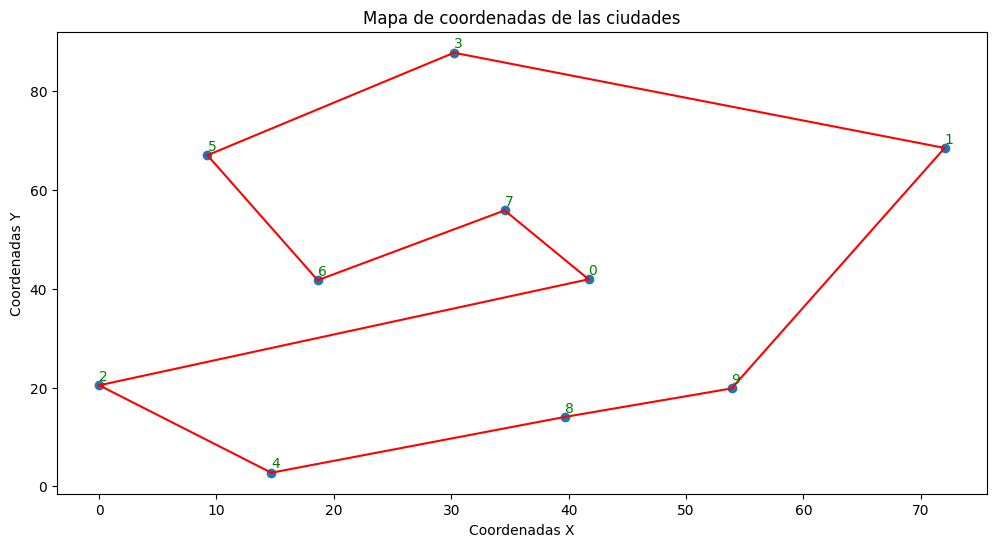

In [ ]:

plt.figure(figsize=(12,6))
plt.scatter(coordenada_x,coordenada_y)
plt.title("Mapa de coordenadas de las ciudades")
plt.xlabel("Coordenadas X")
plt.ylabel("Coordenadas Y")

for n in range(len(NN)-1):
    plt.plot([coordenada_x[NN[n]], coordenada_x[NN[n+1]]],
             [coordenada_y[NN[n]], coordenada_y[NN[n+1]]], color='red')
    
for i in range(len(NN)-1):
    plt.annotate(str(i), xy=(coordenada_x[i], coordenada_y[i]), xytext=(coordenada_x[i], coordenada_y[i]+1), color='green')


plt.show()
